# Approach 2: Random Forest Regression
![RandomForest](https://static.vecteezy.com/system/resources/previews/007/633/589/original/illustration-of-summer-landscape-smoky-forest-green-mist-mountains-hiking-background-in-flat-banner-style-free-vector.jpg)

Authors:
- Stephen Hwang
- Shoumik Chaudhuri

## Part 0: Project Overview 📝
---
To continue our task of using machine learning models to predict NBA champions for the 2023 year, we decided on a secondary approach to the task using random forest regression models, which will use to make predictions for `Champion Share Score` using relevant features from the dataset.

The tools and packages involved are as follows:
- [Pandas](https://pandas.pydata.org/) and [NumPy](https://numpy.org/) for general data manipulation
- [Matplotlib](https://matplotlib.org/) for visualization
- [Google Colab](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=RWSJpsyKqHjH) to mount Google drive and load dataframes
- [Sklearn](https://scikit-learn.org/) for models & validation metrics

**Language & Environment**

![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54)
![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)

**Packages**

![Pandas](https://img.shields.io/badge/pandas-%23150458.svg?style=for-the-badge&logo=pandas&logoColor=white)
![NumPy](https://img.shields.io/badge/numpy-%23013243.svg?style=for-the-badge&logo=numpy&logoColor=white)
![Matplotlib](https://img.shields.io/badge/Matplotlib-%23ffffff.svg?style=for-the-badge&logo=Matplotlib&logoColor=black)
![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white)



## Part 1. Importing packages and loading the dataset 📦
---

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import warnings


pd.options.mode.chained_assignment = None

In [2]:
drive.mount('/content/gdrive', force_remount = True)

MessageError: ignored

In [ ]:
nba_playoff_contenders = pd.read_excel("/content/gdrive/MyDrive/IEOR 142 NBA Final Project /NBA_playoff_contenders.xlsx")

In [ ]:
nba_playoff_contenders

In [ ]:
nba_playoff_contenders.columns

## Part 2. Training the Random Forest Regression model then evaluating 🌲
---

In [ ]:
# Importing ensemble from sklearn
from sklearn.ensemble import RandomForestRegressor

First, we split the data to training and testing. A 70:30 split of training to testing data was decided upon from previous experiences with splitting data from the many labs and homeworks of IEOR 142.

In [ ]:
from sklearn.model_selection import train_test_split

X = nba_playoff_contenders.drop(["Champion Share Score", "Team"], axis=1) # Removing the feature to predict. Removing team name since its uncessary.
y = nba_playoff_contenders["Champion Share Score"] # The variable we are interested in

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

We are not concerned about sectioning off another validation portion from the training data (like in MLR), as we want to use cross-validation for our random forests model, which will come later.

An initial random forest regression model is trained.

In [ ]:
# Creating the random forest
rf = RandomForestRegressor(max_features = 4, min_samples_leaf = 2,
                           n_estimators = 500, random_state=88, verbose = 0)

rf.fit(X_train, y_train)

RandomForestRegressor(max_features=4, min_samples_leaf=2, n_estimators=500,
                      random_state=88)

We decided to evaluate this model using two metrics to account for in-sample and out-of-sample accuracy. R2 and out-of-sample R2 can help observe if the model is properly accounting for the variation of data both in the training and testing set.

In [ ]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

In [ ]:
# Importing metrics from sklearn then printing them
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
osr2 = r2_score(y_test, y_pred_test)

print("Mean Squared Error:", mse)
print("\nTraining (in-sample) R-squared:", r2)
print("Testing (out-of-sample) R-squared:", osr2)

Mean Squared Error: 0.007798093312048643

Training (in-sample) R-squared: 0.9119353745558948
Testing (out-of-sample) R-squared: 0.5930482906877905


This model in its current state has a large R2 but a smaller OSR2, which means it is likely overfitted.

Using this model, we can also view the feature importance of the columns in `X_train` by viewing `feature_importances_` from the model.

In [ ]:
pd.DataFrame({'Feature' : X_train.columns,
              'Importance score': 100 * rf.feature_importances_}).round(1)

,Feature,Importance score
0,Year,1.0
1,Seed,17.5
2,Playoff Experience,4.9
3,Age,1.8
4,W,8.9
5,L,6.5
6,PW,3.8
7,PL,4.1
8,MOV,7.4
9,SOS,2.6


## Part 3. Tuning hyper-parameters with Grid Search Cross-Validation then evaluating 📈
---

To tune the model and lessen the impact of overfitting, we used grid search cross-validation to create another random forests model.

### Selecting best hyper-parameters by using Grid Search Cross-Validation

In [ ]:
# Importing KFold and GridSearch CV
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [ ]:
# The grid values for tuning hyper-parameters. min_samples_leaf, n_estimators,
# and random_state are left as a constant, while max_features is a list
# containing all numbers between 1 and the max number of independent columns, 26
grid_values = {'max_features': np.linspace(1,26,26, dtype='int32'),
               'min_samples_leaf': [2],
               'n_estimators': [500],
               'random_state': [42]}

In [ ]:
# Creating the model to be used for grid search CV
rf2 = RandomForestRegressor()
cv = KFold(n_splits = 5, random_state = 333, shuffle=True)

rf_cv = GridSearchCV(rf2, param_grid = grid_values,
                     scoring = 'r2', cv=cv, verbose = 0)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=333, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int32),
                         'min_samples_leaf': [2], 'n_estimators': [500],
                         'random_state': [42]},
             scoring='r2')

We can similarly view feature importances for this newer model as well.

In [ ]:
pd.DataFrame({'Feature' : X_train.columns,
              'Importance score': 100 * rf.feature_importances_}).round(1).sort_values("Importance score", ascending = False)

,Feature,Importance score
1,Seed,17.5
4,W,8.9
8,MOV,7.4
13,NRtg,6.7
10,SRS,6.7
5,L,6.5
2,Playoff Experience,4.9
7,PL,4.1
6,PW,3.8
17,TS%,2.7


Once the grid search CV model is fitted, we visualize the R2 vs. the number of features using matplotlib.

(0.3, 0.7)

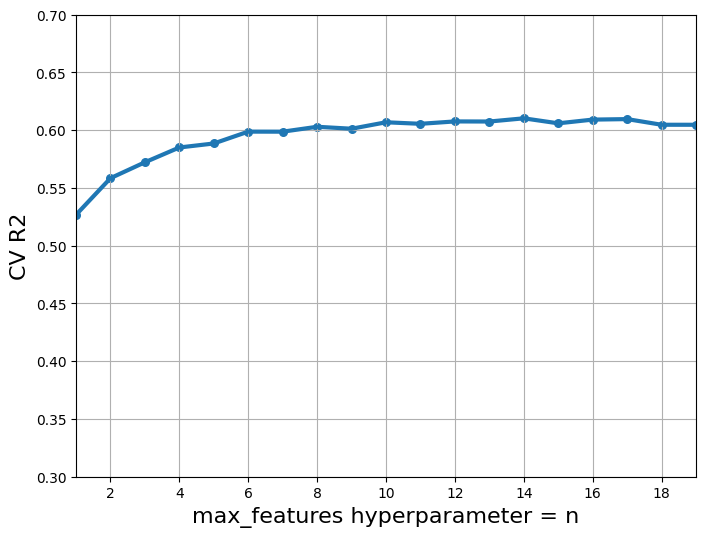

In [ ]:
import matplotlib.pyplot as plt
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize = (8, 6))
plt.xlabel('max_features hyperparameter = n', fontsize = 16)
plt.ylabel('CV R2', fontsize = 16)
plt.scatter(max_features, R2_scores, s = 30)
plt.plot(max_features, R2_scores, linewidth = 3)
plt.grid(True, which = "both")
plt.xlim([1, 19])
plt.ylim([0.3, 0.7])

In [ ]:
print(rf_cv.best_params_)

{'max_features': 14, 'min_samples_leaf': 2, 'n_estimators': 500, 'random_state': 42}


We can identify visually (and through `best_params_`) that cross-validated R2 reaches its peak at 14 max features. The model performance using this parameter can also be analyzed to evaluate performance.

In [ ]:
# Helper function to check OSR2 values for a specific model

def OSR2(model, X_test, y_test, y_train):
    '''
    Helper function to calculate OSR2 value for a model and training/testing
    data. Pulled from labs in IEOR 142 from sp23 semester. (Lab9a)

    Args:
      model (sklearn): The trained model being tested
      X_test (dataframe): A df representing independent variable in TESTING set
      y_test (series): A series representing the dependent variable in TEST set
      y_train (Series): A series representing the dependent variable in TEST set
    '''

    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)

    return (1 - SSE/SST)

In [ ]:
print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(OSR2(rf_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.6103
OSR2: 0.58037


Similarly to our initial model, we can also check for feature importance.

In [ ]:
pd.DataFrame({'Feature' : X_train.columns,
              'Importance score': 100 * rf_cv.best_estimator_.feature_importances_}).round(1).sort_values("Importance score", ascending = False).reset_index(drop = True)

,Feature,Importance score
0,Seed,36.8
1,W,8.4
2,Playoff Experience,5.8
3,MOV,4.8
4,L,4.5
5,NRtg,3.9
6,SRS,3.7
7,Opp FT/FGA,2.5
8,ORtg,2.3
9,TS%,2.2


## Scratch Work 📔
---

In [ ]:
nba_playoff_contenders.columns

Index(['Team', 'Year', 'Seed', 'Champion Share Score', 'Playoff Experience',
       'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg',
       'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA',
       'Opp eFG%', 'Opp TOV%', 'DRB%', 'Opp FT/FGA'],
      dtype='object')

In [ ]:
def find_best_max_features(X_train, y_train, x_test, y_test):
  """
  Given a training set and a test set, create and test out multiple
  RandomForestRegressor models, then return the number of max_features that
  provides the highest OSR2 value.
  """
  max_features = np.linspace(1,26,26, dtype='int32')

  best_max_features = 0
  highest_osr2 = 0

  for max_feature in max_features:
    rf = RandomForestRegressor(max_features = max_feature, min_samples_leaf = 2,
                               n_estimators = 500, random_state = 42, verbose = 0)
    rf.fit(X_train, y_train)

    y_pred_test = rf.predict(X_test)

    osr2 = r2_score(y_test, y_pred_test)
    print("Current max_features: " + str(max_feature))
    print("Current OSR2: " + str(osr2))
    if osr2 > highest_osr2:
      best_max_features = max_feature
      highest_osr2 = osr2

  return best_max_features, highest_osr2

In [ ]:
find_best_max_features(X_train, y_train, X_test, y_test)

Current max_features: 1
Current OSR2: 0.5502087079794086
Current max_features: 2
Current OSR2: 0.573687395317644
Current max_features: 3
Current OSR2: 0.5875746994734536
Current max_features: 4
Current OSR2: 0.5928125824652675
Current max_features: 5
Current OSR2: 0.5903281857697271
Current max_features: 6
Current OSR2: 0.5822930683631098
Current max_features: 7
Current OSR2: 0.5913064464726734
Current max_features: 8
Current OSR2: 0.591592169302276
Current max_features: 9
Current OSR2: 0.5917826730849753
Current max_features: 10
Current OSR2: 0.5849470897754196
Current max_features: 11
Current OSR2: 0.5871435904966298
Current max_features: 12
Current OSR2: 0.5831028002773595
Current max_features: 13
Current OSR2: 0.5808157319702874
Current max_features: 14
Current OSR2: 0.5780845675184023
Current max_features: 15
Current OSR2: 0.5761054853394338
Current max_features: 16
Current OSR2: 0.5705059327938593
Current max_features: 17
Current OSR2: 0.572023025843696
Current max_features: 18
C

(4, 0.5928125824652675)

In [ ]:
y_pred_train

array([0.23574057, 0.07607901, 0.2207552 , 0.24655415, 0.88589125,
       0.10926719, 0.10878309, 0.72673197, 0.83903086, 0.62693637,
       0.08905752, 0.26639442, 0.48480503, 0.42762169, 0.23925141,
       0.26257058, 0.19384685, 0.14820307, 0.08379013, 0.13135125,
       0.20225414, 0.45106085, 0.10287161, 0.71706089, 0.14617619,
       0.35670932, 0.13216357, 0.08832008, 0.50421348, 0.08642451,
       0.22506887, 0.12718536, 0.06561953, 0.19057252, 0.92283992,
       0.05790944, 0.09144099, 0.87859294, 0.08788894, 0.9415778 ,
       0.22152903, 0.11992562, 0.58164636, 0.59085329, 0.42432687,
       0.08460662, 0.5994096 , 0.21240908, 0.26257058, 0.13988714,
       0.16839938, 0.14651331, 0.52128505, 0.20569429, 0.48363902,
       0.26038928, 0.25599846, 0.12407095, 0.67012962, 0.10927678,
       0.09129085, 0.22481875, 0.13898897, 0.76662355, 0.13376894,
       0.25869393, 0.76662355, 0.10886654, 0.78419302, 0.42985524,
       0.12277782, 0.75672377, 0.55029515, 0.36375038, 0.84194

In [ ]:
nba_playoff_contenders_2023 = pd.read_excel("/content/gdrive/MyDrive/IEOR 142 NBA Final Project /NBA_playoff_contenders_2023.xlsx")

In [ ]:
# last_year = nba_playoff_contenders[nba_playoff_contenders["Year"] == 2012]

# #last_year = nba_playoff_contenders_2023.drop(10)
# last_year_dropped = last_year.drop(columns = ["Team", "Champion Share Score"])
# last_year["Predicted CSS"] = rf_cv.predict(last_year_dropped)
# last_year = last_year.sort_values("Predicted CSS", ascending = False)
# last_year

def predict_champion(year):
    if year == 2023:
        last_year = nba_playoff_contenders_2023.drop(10)
    else:
        last_year = nba_playoff_contenders[nba_playoff_contenders["Year"] == year]
    last_year_dropped = last_year.drop(columns = ["Team", "Champion Share Score"])
    last_year["Predicted CSS"] = rf_cv.predict(last_year_dropped)
    last_year = last_year.sort_values("Predicted CSS", ascending = False)
    return last_year["Team"].iloc[0]

In [ ]:
# Predicting the champion for each year!
predictions_by_year = [(year, predict_champion(year)) for year in range(2008, 2023)]
predictions_by_year

[(2008, 'Los Angeles Lakers*'),
 (2009, 'Los Angeles Lakers*'),
 (2010, 'Los Angeles Lakers*'),
 (2011, 'Dallas Mavericks*'),
 (2012, 'Miami Heat*'),
 (2013, 'Miami Heat*'),
 (2014, 'San Antonio Spurs*'),
 (2015, 'Golden State Warriors*'),
 (2016, 'Golden State Warriors*'),
 (2017, 'Golden State Warriors*'),
 (2018, 'Golden State Warriors*'),
 (2019, 'Toronto Raptors*'),
 (2020, 'Los Angeles Lakers*'),
 (2021, 'Philadelphia 76ers*'),
 (2022, 'Golden State Warriors*')]

In [ ]:
predict_champion(2023)

'Milwaukee Bucks*'

In [ ]:
last_year = nba_playoff_contenders_2023.drop(10)
last_year_dropped = last_year.drop(columns = ["Team", "Champion Share Score"])
last_year["Predicted CSS"] = rf_cv.predict(last_year_dropped)
last_year = last_year.sort_values("Predicted CSS", ascending = False)

last_year

,Team,Year,Seed,Champion Share Score,Playoff Experience,Age,W,L,PW,PL,...,TS%,eFG%,TOV%,ORB%,FT/FGA,Opp eFG%,Opp TOV%,DRB%,Opp FT/FGA,Predicted CSS
4,Milwaukee Bucks*,2023,1,0.0625,756,29.8,58,24,50,32,...,0.583,0.555,12.7,25.0,0.184,0.520,10.4,77.8,0.175,0.682958
0,Boston Celtics*,2023,2,0.375,676,27.4,57,25,57,25,...,0.600,0.566,12.0,22.1,0.197,0.528,11.3,78.5,0.180,0.655557
2,Philadelphia 76ers*,2023,3,0.375,562,28.2,54,28,52,30,...,0.608,0.563,12.6,21.6,0.250,0.541,13.0,77.2,0.217,0.617207
5,Denver Nuggets*,2023,1,0.375,425,26.6,53,29,49,33,...,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,0.528736
3,Memphis Grizzlies*,2023,2,0.125,135,24.4,51,31,51,31,...,0.570,0.540,11.7,26.5,0.190,0.526,13.1,75.9,0.206,0.486255
13,Los Angeles Clippers*,2023,5,0.0625,668,29.7,44,38,42,40,...,0.588,0.551,12.8,22.9,0.217,0.543,11.7,76.6,0.195,0.451088
7,Sacramento Kings*,2023,3,0.1875,130,25.4,48,34,47,35,...,0.608,0.572,12.0,22.7,0.225,0.563,12.6,77.2,0.203,0.419314
1,Cleveland Cavaliers*,2023,4,0.0625,310,25.4,51,31,55,27,...,0.590,0.556,12.3,23.6,0.206,0.535,14.4,76.3,0.210,0.392391
6,New York Knicks*,2023,5,0.3125,98,24.5,47,35,48,34,...,0.577,0.541,11.4,28.3,0.217,0.536,11.4,77.1,0.210,0.389696
8,Phoenix Suns*,2023,4,0.375,618,28.1,45,37,46,36,...,0.570,0.535,12.0,26.6,0.191,0.532,12.9,76.0,0.234,0.319375


In [ ]:
0.682958 - 0.655557

0.02740100000000001